# Aircraft Engine RUL Prediction

Prediction of Remaining Useful Life of any machine is very essential due to its ability to prevent failure occurrences and maintenance costs. At present, mathematical and statistical modeling are the prominent approaches used for it. These are based on equipment degradation physical models and machine learning methods, respectively.

So, the objecive is to develop a system that identifies likelihood of failure of rotating equipment (for example motors, turbines) based on a stream of sensor data. The sensors monitor different parameters such as temperature, pressure and acceleration of different machine parts in order to keep a check on the performance of the rotary machine. At the server side, this data is used to train a machine learning model. This model predicts the remaining useful life (RUL) i.e., time to failure of the machine. These predictions are used to prevent failure of the machines by performing maintenance at appropriate time.

## Data
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1) unit number

2) time, in cycles

3) operational setting 1

4) operational setting 2

5) operational setting 3

6) sensor measurement 1

7) sensor measurement 2

...

26) sensor measurement 26

The training set includes operational data from 100 different engines. In each data set, the engine was run for a variable number of cycles until failure. The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cylces.

The testing set includes operational data from 100 different engines. The engines in the test dataset and completely different from engines in the training data set.

## Objectives of This Study
Objective of this project is to implement various Predictive Maintenance methods on this dataset and assess the performance of each.

1. Build a best machine learning model to predict the remaining useful life
2. Build a Classification model which predicts if an engine is going to fail using past 40 cycles data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')
%matplotlib inline

## Import ML algorithm libraries
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Import Model evaluation libraries
from sklearn import metrics

## 1. Class Definition to Load the Train, Test and RUL Data

In [5]:
class Data_Getter:
    """
    This class shall be used to obtain the data from the source directory for training
    
    Written by: Pradeep Hegde
    Version: 1.0
    Revision: 0.1
        
    """
    def __init__(self):
        self.training_file = "Training_data/train_FD001.txt"
        self.testing_file = "Training_data/test_FD001.txt"
        self.RUL_file = "Training_data/RUL_FD001.txt"
       
    def get_data(self):
        """
            Method name: get_data
            Description: This method is used to read data from the source
            Output: This method outputs a pandas dataframe
            On failure: Raise exception
            
            Written by: Pradeep Hegde
            Version: 1.0
            Revision: 0.1
        
            """
        try:
            self.data_train = pd.read_csv(self.training_file, delim_whitespace=True, header=None) #Reading the data file as dataframe
            self.data_test = pd.read_csv(self.testing_file, delim_whitespace=True, header=None) #Reading the data file as dataframe
            self.data_RUL = pd.read_csv(self.RUL_file, delim_whitespace=True, header=None)
            return self.data_train, self.data_test, self.data_RUL
        except Exception as e:
            print(e)
    

## 2. Class for EDA

In [6]:
# Setting the column names for input data
dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Flight_Cycles"]
operational_settings_columns_names = ["OperSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
df_train = pd.read_csv('D:/Data_science/ML_CV_Build_Projects/CV2_Predictive_Aero/Training_data/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

In [28]:
class data_eda:
    
    def pair_plot1(self, data_train):
        self.df_plot1 = data_train.iloc[:,2:14]
        self.df_plot2 = data_train.iloc[:,14:26]
        sns.pairplot(self.df_plot1)
        
    def pair_plot2(self):
        sns.pairplot(self.df_plot2)

In [27]:
data_eda = data_eda()

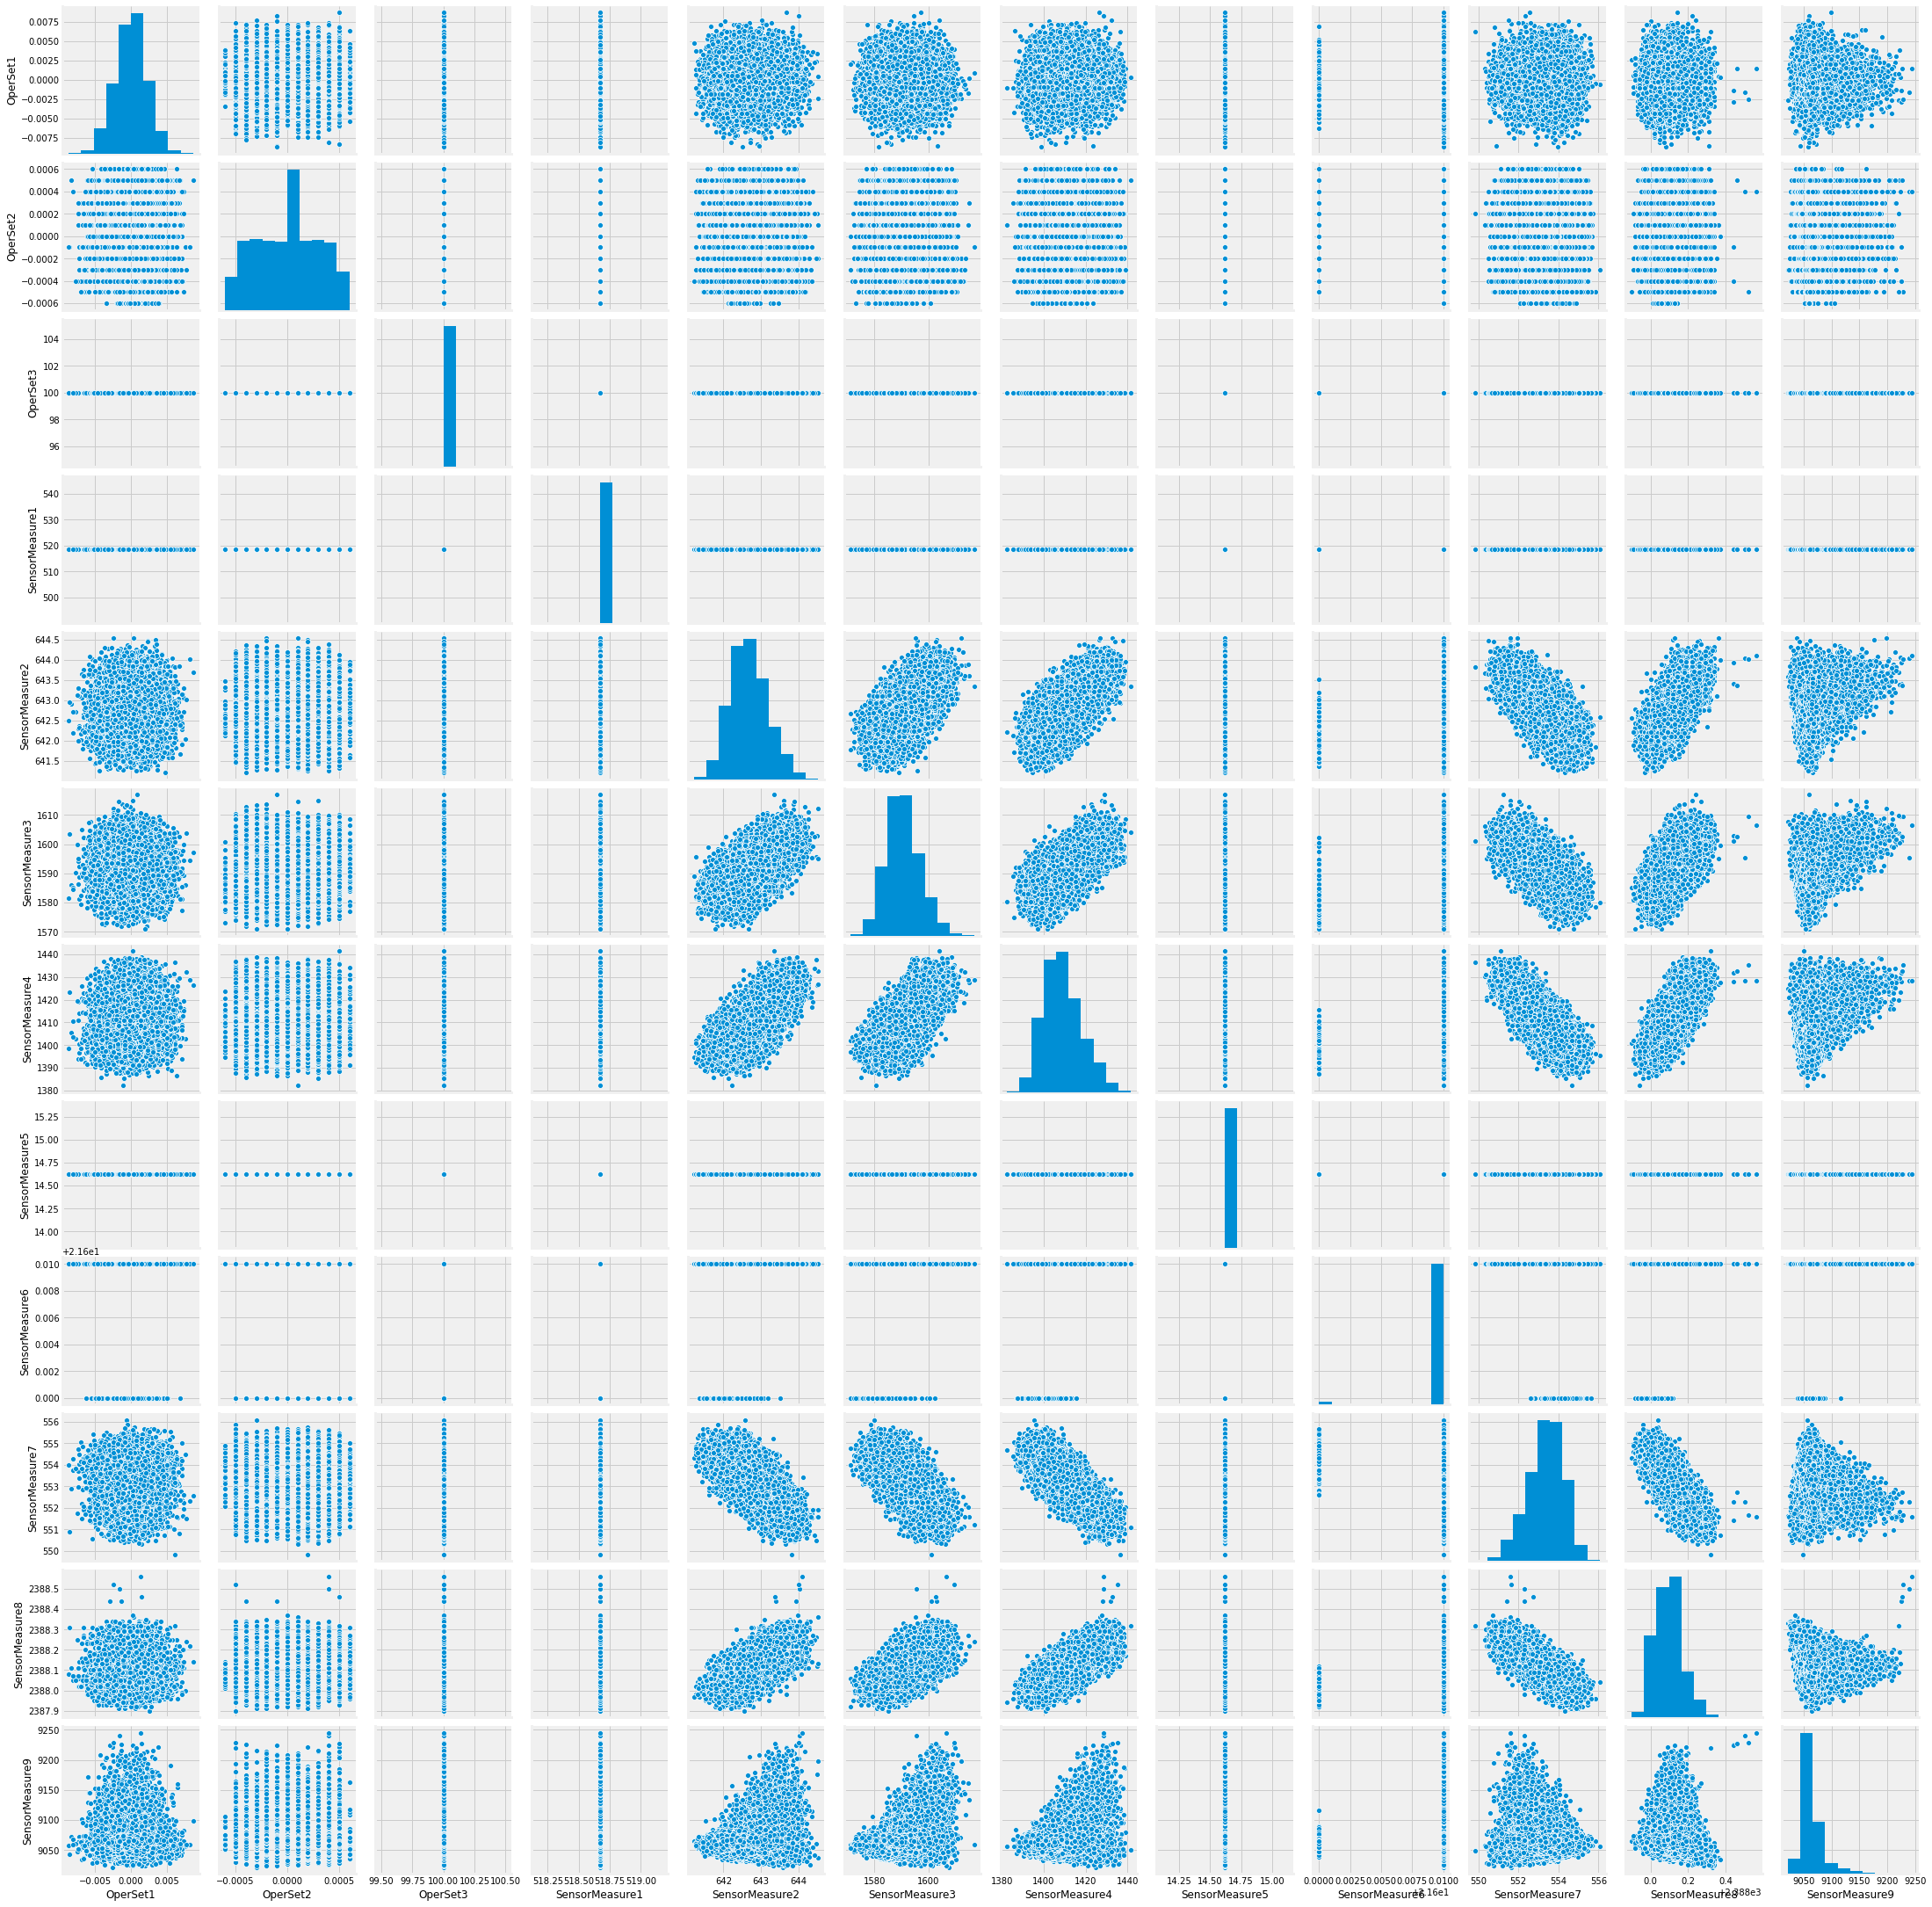

In [209]:
data_eda.pair_plot1(df_train)

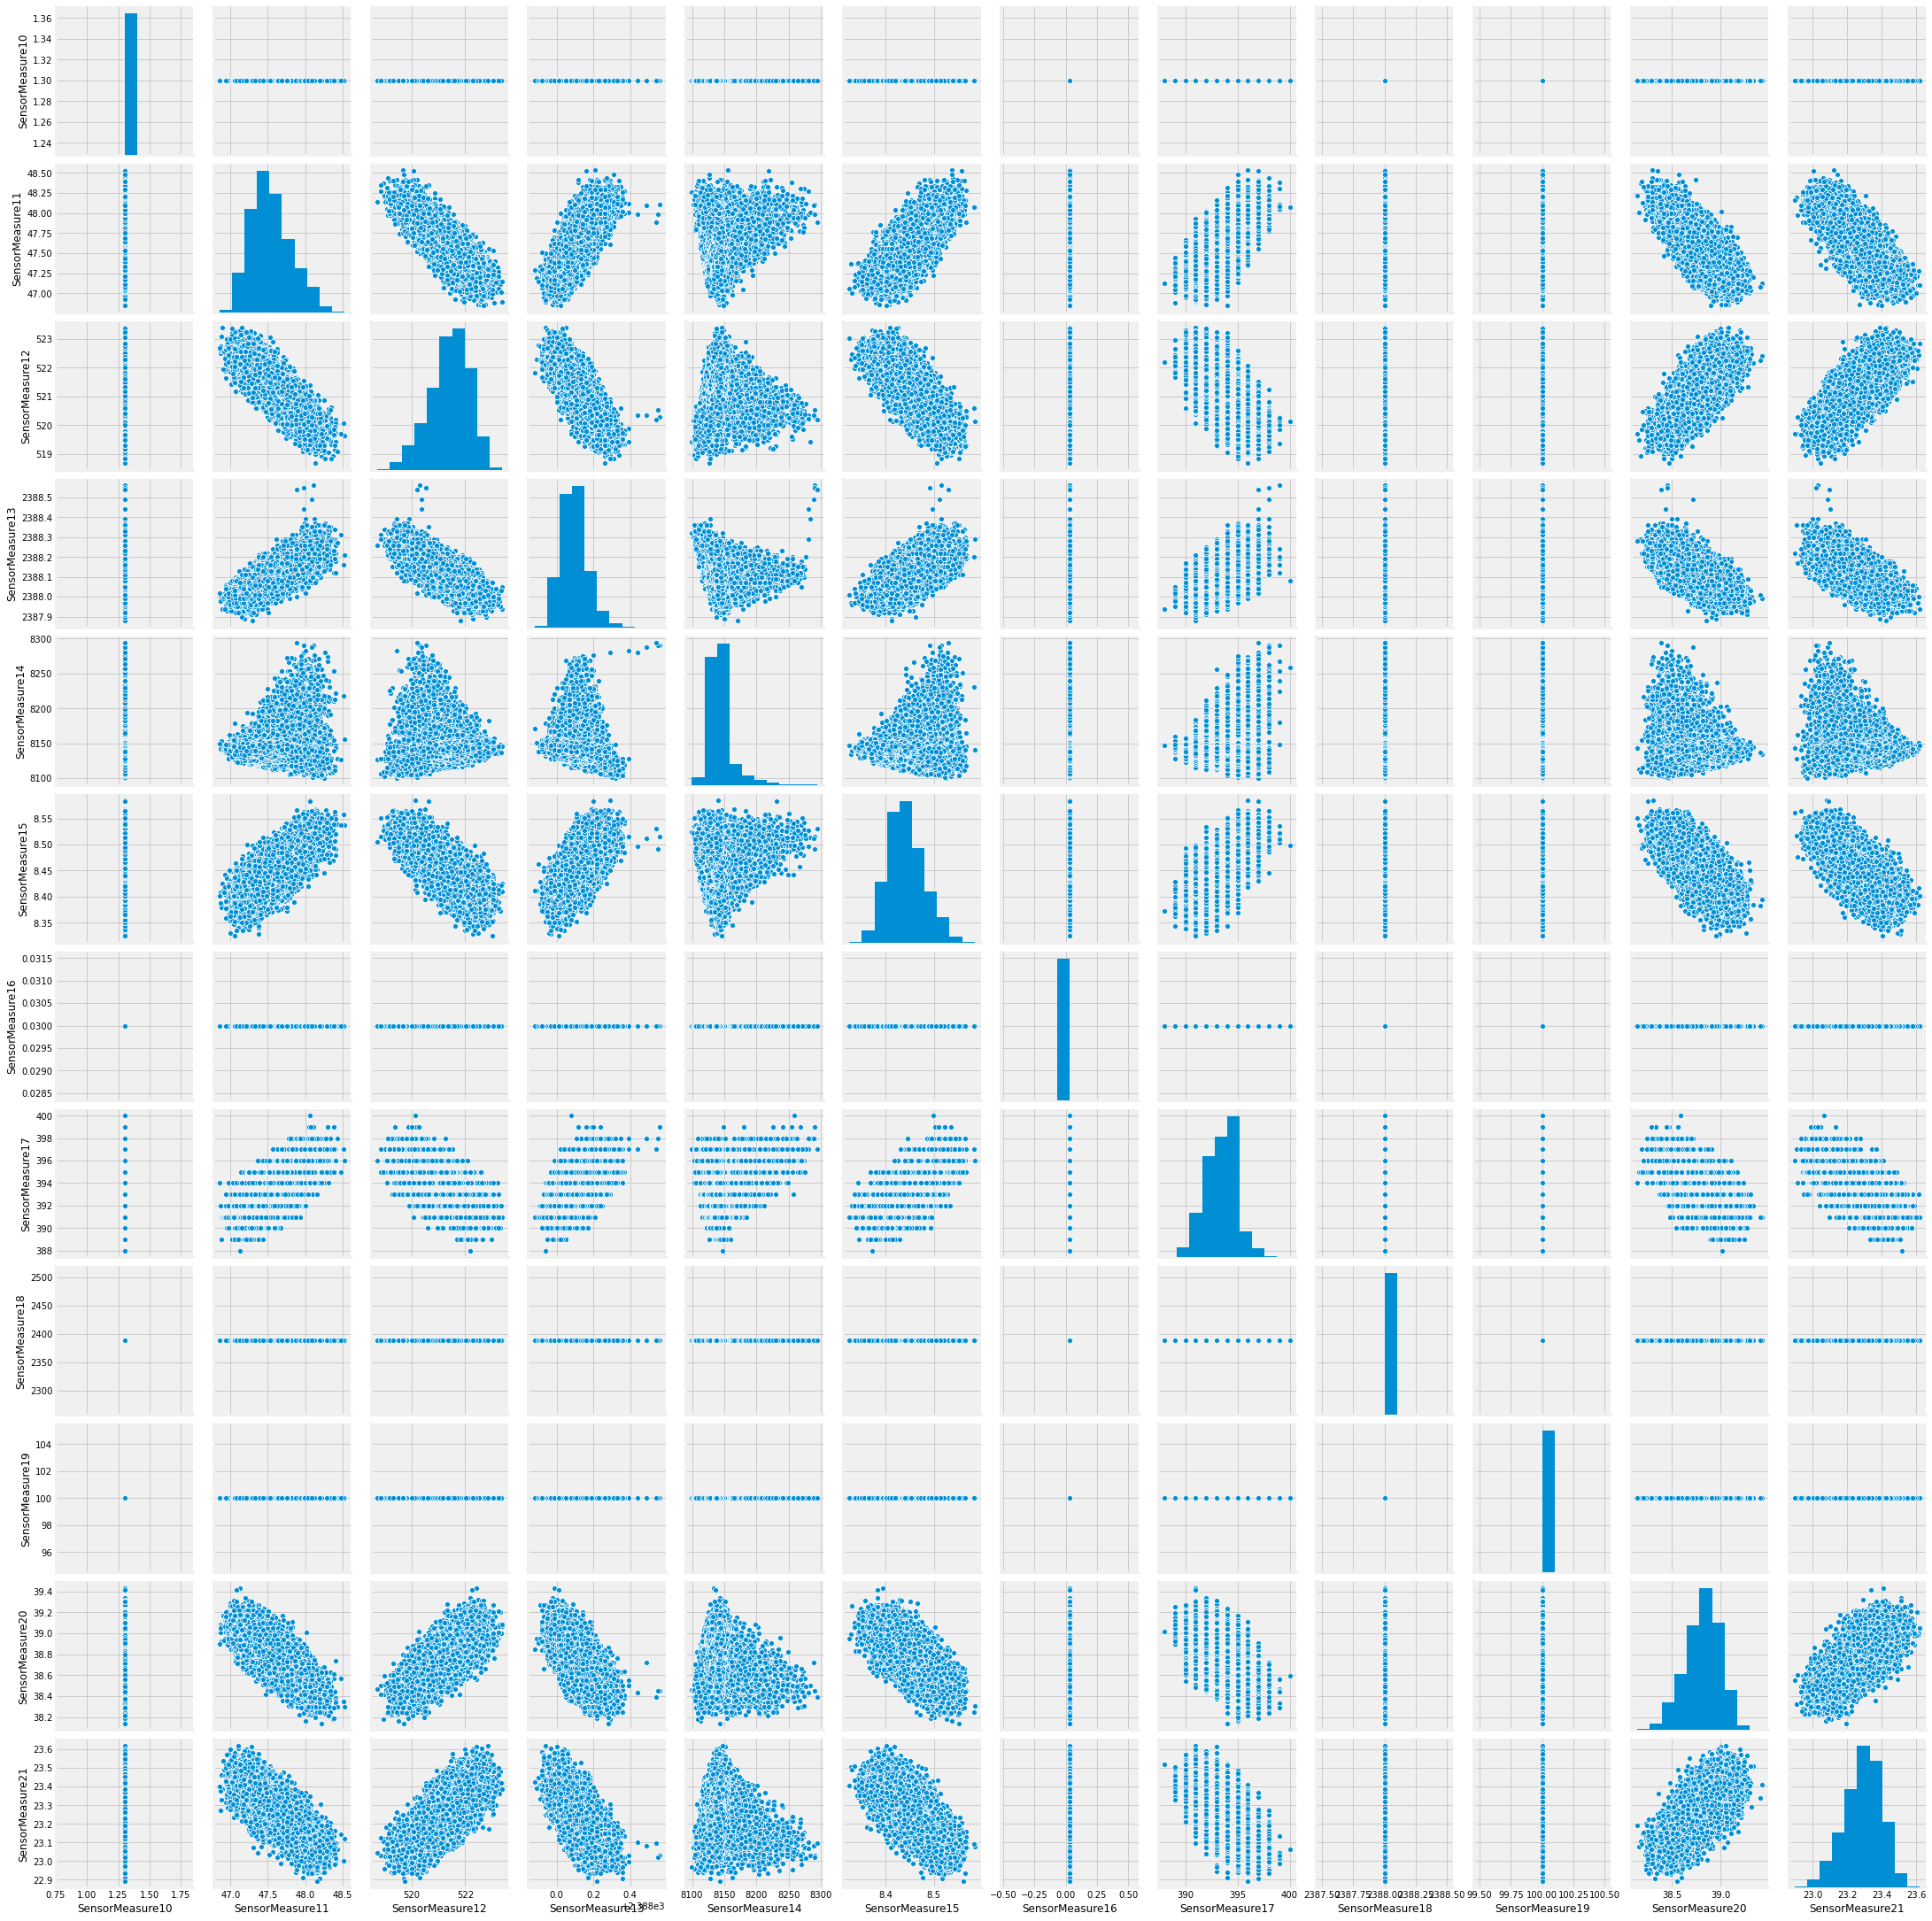

In [210]:
data_eda.pair_plot2()

## 3. Class Definition to Pre-process the Data

In [9]:
class Preprocessor:
    """
        This class shall be used to clean and transform the data before training.
        
        Written by: Pradeep Hegde
        Version: 1.0
        Revision: 0.1
            
        """
    def add_column_name(self, data_train, data_test, data_RUL):
        """
                Method Name: add_column_name
                Description: This method add column names to a pandas dataframe.
                Output: A pandas dataframe after adding column names.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Verison: 1.0
                Revision: 0.1
                
            """  
        self.data_train = data_train
        self.data_test = data_test
        self.data_RUL = data_RUL
        self.column_unit_cycle = ["UnitNumber","Flight_Cycles"]
        self.column_operational_settings = ["OperSet"+str(i) for i in range(1,4)]
        self.column_sensor_measure =["SensorMeasure"+str(i) for i in range(1,22)]
        self.column_names = self.column_unit_cycle + self.column_operational_settings + self.column_sensor_measure

        try:
            self.data_train.columns = self.column_names
            self.data_test.columns = self.column_names
            self.data_RUL.columns = ['RUL'] 
            return self.data_train, self.data_test, self.data_RUL
        except Exception as e:
            print(e)

    def add_RUL_column(self, data_train):
        """
                Method Name: add_RUL_column
                Description: This method add RUL names to a pandas dataframe.
                Output: A pandas dataframe after adding RUL names.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Verison: 1.0
                Revision: 0.1
                
            """  
        self.data_train = data_train
        try:
            self.rul = pd.DataFrame(self.data_train.groupby('UnitNumber')['Flight_Cycles'].max()).reset_index()
            self.rul.columns = ['UnitNumber', 'max']
            self.data_train = self.data_train.merge(self.rul, on=['UnitNumber'], how='left')
            self.data_train['RUL'] = self.data_train['max'] - self.data_train['Flight_Cycles']
            self.data_train.drop('max', axis=1, inplace=True)
            return self.data_train
        except Exception as e:
            print(e)
            
    def remove_columns(self, data, columns):
        """
                Method Name: Remove columns
                Description: This method removes the given columns from a pandas dataframe.
                Output: A pandas dataframe after remoing the specified columns.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Verison: 1.0
                Revision: 0.1
                
            """
        
        self.data = data
        self.columns = columns
        try:
            self.useful_data = self.data.drop(labels=self.columns, axis=1) #Drop the labels specified in the columns
            return self.useful_data
        except Exception as e:
            print(e)
            
    def separate_label_feature(self, data, label_column_name):
        """
                    Method name: separate_label_feature
                    Description: This method separates the features and a label column.
                    Output: Returns two separate Dataframes, one containing features and the other containing Labels.
                    On failure: Raise exception

                    Written by: Pradeep Hegde
                    Version: 1.0
                    Revision: 0.1
                    Referece: iNeuron

                """
        try:
            self.X = data.drop(labels=label_column_name, axis=1) # drop the specified column
            self.y = data[label_column_name] #Filter the labeled column
            return self.X, self.y
        except Exception as e:
            print(e)            
            
    def is_null_present(self, data):
        """
                Method name: is_null_present
                Description: This method checks for null entries present in the pandas dataframe.
                Output: Returns a boolean value. True if null values are present in the dataframe, False if they are not present.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Version: 1.0
                Revision: 0.1
                Referece: iNeuron
                
            """
        self.null_present = False
        try:
            self.null_counts = data.isna().sum() # check for the count of null values per column
            if self.null_counts.sum() > 0:
                self.null_present = True
            
            if(self.null_present): # write the logs to see which columns have null values
                dataframe_with_null = pd.DataFrame()
                dataframe_with_null['columns'] = self.null_counts.index
                dataframe_with_null['missing values count'] = self.null_counts.tolist()
                dataframe_with_null.to_csv('preprocessing_data/null_values.csv') # storing the null column information to file
            return self.null_present
        except Exception as e:
            print(e)
    
    def impute_missing_values(self, data):
        """
                Method name: impute_missing_value
                Description: This method replaces all the missing values in the dataframe using KNN Imputer.
                Output: A dataframe which has all the missing values imputed.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Version: 1.0
                Revision: 0.1
                Referece: iNeuron            
                
            """
        self.data= data
        try:
            imputer = KNNImputer(n_neighbors=3, weights='uniform', missing_values=np.nan)
            self.new_array=imputer.fit_transform(self.data) # impute the missing values
            # convert the nd-array returned in the step above to a Dataframe
            self.new_data=pd.DataFrame(data=self.new_array, columns=self.data.columns)
            return self.new_data
        except Exception as e:
            print(e)                
                
    def get_columns_with_zero_std_deviation(self,data):
        """
                                                Method Name: get_columns_with_zero_std_deviation
                                                Description: This method finds out the columns which have a standard deviation of zero.
                                                Output: List of the columns with standard deviation of zero
                                                On Failure: Raise Exception

                                                Written By: iNeuron Intelligence
                                                Version: 1.0
                                                Revisions: None
                             """
        self.stat_summary = data.describe()
        try:
            self.list_zero_std = self.stat_summary.T[self.stat_summary.loc['std'] < 0.00001].index.to_list()
            return self.list_zero_std

        except Exception as e:
            print(e)                

    def get_columns_with_corr(self,data,value=float):
        """
                                                Method Name: get_columns_with_corr
                                                Description: This method generate a list of columns with high co-rrelation to remove from dataframe.
                                                Output: List of columns with high co-rrelation
                                                On Failure: Raise Exception

                                                Written By: Pradeep Hegde
                                                Version: 1.0
                                                Revisions: None
                             """
        self.data_train = data
        self.value = value
        self.stat_summary = data.describe()
        try:
            self.cor = self.data_train.drop(labels=['UnitNumber','Flight_Cycles'], axis=1).corr()
            self.num_feat = len(self.cor)
            self.list_corr = []
            for i in range(0, self.num_feat):
                for j in range(0, self.num_feat):
                    if j > i and self.cor.iloc[i, j] > self.value:
                        self.list_corr.append(self.cor.columns[j])
            return self.list_corr

        except Exception as e:
            print(e)               
                
                
    def impute_with_random_sample(self, data, variable):
        """
                Method name: impute_with_random_sample
                Description: This method replaces the missing values in the column of dataframe using random sample.
                Output: A dataframe which has all the missing values imputed.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Version: 1.0
                Revision: 0.1
                Referece: iNeuron            
                
            """
        self.data = data
        try:
            self.data[variable+"_random"] = self.data[variable]
            random_sample = self.data[variable].dropna().sample(self.data[variable].isnull().sum(), random_state=0) # impute the missing values
            random_sample.index = self.data[self.data[variable].isnull()].index
            self.data.loc[self.data[variable].isnull(),variable+"_random"] = random_sample
            return self.new_data
        except Exception as e:
            print(e)  
            
    def df_result(self, data_test, data_RUL):
        """
                Method Name: df_result
                Description: This method converts the test data frame to required format to store the results.
                Input: test dataset (data_test) and true output (data_RUL)
                Output: A pandas dataframe for storing results.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Verison: 1.0
                Revision: 0.1
                
            """  
        self.temp_test = data_test
        try:
            self.rul = pd.DataFrame(self.temp_test.groupby('UnitNumber')['Flight_Cycles'].max()).reset_index()
            self.rul.columns = ['UnitNumber', 'max']
            self.temp_test = self.temp_test.merge(self.rul, on=['UnitNumber'], how='left')
            self.data_result = self.temp_test[self.temp_test['Flight_Cycles'] == self.temp_test['max']].reset_index()
            self.data_result['RUL_true'] = data_RUL['RUL']
            return self.data_result
        except Exception as e:
            print(e)
            

## 4. Class for Building the Models for Training the Dataset

In [58]:
## Import ML algorithm libraries
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Import Model evaluation libraries
from sklearn import metrics
class models:
    """
        This class shall be used to train the dataset and find the best model.
        
        Written by: Pradeep Hegde
        Version: 1.0
        Revision: 0.1
            
        """
    def rf_model(self, data_train, X_test, n_est, criterion, max_d, min_samp, min_samp_leaf, max_feat):
        """
                Method Name: rf_model
                Description: This method is used to build random forest regression model.
                Output: A pandas dataframe after adding column names.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Verison: 1.0
                Revision: 0.1
                
            """  
        self.n_est = n_est
        self.criterion = criterion
        self.max_d = max_d
        self.min_samp = min_samp
        self.min_samp_leaf = min_samp_leaf
        self.max_feat = max_feat
        self.X = data_train.iloc[:,:-1]
        self.y = data_train.iloc[:,-1]
        self.RUL_true = X_test.iloc[:,-1].to_numpy().reshape(-1,1)
        self.df_test = X_test.iloc[:,:-2]
        #print(self.df_test)
        try:
            rf_reg = RandomForestRegressor(n_estimators=self.n_est,
                                          criterion = self.criterion,
                                          min_samples_split = self.min_samp, 
                                          min_samples_leaf = self.min_samp_leaf, 
                                          max_features = self.max_feat, 
                                          max_depth = self.max_d, 
                                          n_jobs=-1, 
                                          random_state=1)   
            rf_reg.fit(self.X, self.y)
            RUL_pred = rf_reg.predict(self.df_test)
            score = rf_reg.score(self.df_test, self.RUL_true)
            mse = metrics.mean_squared_error(self.RUL_true, RUL_pred)
            r2_score = metrics.r2_score(self.RUL_true, RUL_pred)
            return [self.n_est,self.criterion,self.max_d,self.min_samp,self.min_samp_leaf,self.max_feat,mse,score,r2_score], RUL_pred
            #print(mse, score, r2_score)
            #print([self.n_est,self.criterion,self.max_d,self.min_samp,self.min_samp_leaf,self.max_feat,mse,score,r2_score])
        except Exception as e:
            print(e)

            
    def xgb_model(self, data_train, X_test, colsample_bytree, learning_rate, max_depth, alpha, n_est):
        """
                Method Name: rf_model
                Description: This method is used to build random forest regression model.
                Output: A pandas dataframe after adding column names.
                On failure: Raise exception
                
                Written by: Pradeep Hegde
                Verison: 1.0
                Revision: 0.1
                
            """  
        self.colsample_bytree = colsample_bytree
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.alpha = alpha
        self.n_est = n_est
        self.X = data_train.iloc[:,:-1]
        self.y = data_train.iloc[:,-1]
        self.RUL_true = X_test.iloc[:,-1].to_numpy().reshape(-1,1)
        self.df_test = X_test.iloc[:,:-2]
        #print(self.df_test)
        try:
            xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                                            colsample_bytree = self.colsample_bytree,
                                            learning_rate = self.learning_rate,
                                            max_depth = self.max_depth,
                                            alpha = self.alpha,
                                            n_estimators = self.n_est)   
            xg_reg.fit(self.X, self.y)
            RUL_pred = xg_reg.predict(self.df_test)
            score = xg_reg.score(self.df_test, self.RUL_true)
            mse = metrics.mean_squared_error(self.RUL_true, RUL_pred)
            r2_score = metrics.r2_score(self.RUL_true, RUL_pred)
            return [self.colsample_bytree,self.learning_rate,self.max_depth,self.alpha,self.n_est,mse,score,r2_score], RUL_pred
            #print(mse, score, r2_score)
            #print([self.n_est,self.criterion,self.max_d,self.min_samp,self.min_samp_leaf,self.max_feat,mse,score,r2_score])
        except Exception as e:
            print(e)            

## 5. Class for Training and Testing the Model

In [60]:
class trainModel:

    def trainingModel(self):
        # Logging the start of training
        try:
            # Getting the data from the source
            data_getter = Data_Getter()
            data_train, data_test, data_RUL  = data_getter.get_data()
            
            """ Doing the data preprocessing """
            # Adding column names
            preprocessor = Preprocessor()
            data_train, data_test, data_RUL = preprocessor.add_column_name(data_train, data_test, data_RUL)
            data_train = preprocessor.add_RUL_column(data_train)
           
            ##Ploting the data
            #data_plot = data_eda()
            #data_plot.pair_plot1(data_train)
            #data_plot.pair_plot2()

            # Removing columns of data_train dataset
            list_zero_std = preprocessor.get_columns_with_zero_std_deviation(data_train)
            list_corr = preprocessor.get_columns_with_corr(data_train, 0.9)
            self.list_remove = list_zero_std + list_corr
            self.data_train = preprocessor.remove_columns(data_train, self.list_remove) # Remove the unnamed column
            self.data_test = preprocessor.remove_columns(data_test, self.list_remove) # Remove the unnamed column
            # Creating result dataframe from test dataframe
            self.data_result = preprocessor.df_result(data_test, data_RUL)
            self.X_test = preprocessor.remove_columns(self.data_result, self.list_remove)
            self.X_test = preprocessor.remove_columns(self.X_test, ['index'])
            
            # Building Random Forest Model
            self.rf_res_list = []
            self.RUL_pred_rf = []
            self.model = models()
            self.n_est = [40,50,60]
            self.criterion = ['mse']
            self.min_samples_split = [3,5,7] 
            self.min_samples_leaf = [2,4, 6] 
            self.max_features = [4, 7, 15]
            self.max_depth = [3, 5, 10]
            for i in range(3):
                rf_res, RUL_pred = self.model.rf_model(self.data_train, self.X_test,self.n_est[i],self.criterion[0],self.max_depth[i],
                                          self.min_samples_split[i],self.min_samples_leaf[i],self.max_features[i])
                self.rf_res_list.append(rf_res)
                self.RUL_pred_rf.append(RUL_pred)
   
            # Building XG Boost Model
            self.xg_res_list = []
            self.RUL_pred_xg = []
            self.colsample_bytree = [0.3, 0.5, 0.6]
            self.learning_rate = [0.05, 0.1, 0.15]
            self.max_depth = [3, 5, 10]
            self.alpha = [5, 10, 15]
            self.n_est = [20,30,40]
            for i in range(3):
                xg_res, RUL_pred = self.model.xgb_model(self.data_train, self.X_test,self.colsample_bytree[i], 
                                              self.learning_rate[i],self.max_depth[i],self.alpha[i],self.n_est[i])
                self.xg_res_list.append(xg_res)                
                self.RUL_pred_xg.append(RUL_pred)
                
            return  self.data_train, self.data_test, self.data_result, self.X_test, self.rf_res_list, self.xg_res_list, self.RUL_pred_rf, self.RUL_pred_xg
            #return self.rf_res_list
        except Exception as e:
            print(e)

## 6. Model Testing and Evaluation

In [61]:
## Create an object of the trainModel class
trainObj = trainModel()
## Store the output from the trainModel class
data_train, data_test, data_result, X_test, rf_res_list, xg_res_list, RUL_pred_rf, RUL_pred_xg = trainObj.trainingModel()
df_rf = pd.DataFrame(rf_res_list, columns=['n_est','criterion','max_depth','min_samples_split',
                                                'min_samples_leaf','max_features','MSE','Score','R2_score']) 
df_xgb = pd.DataFrame(xg_res_list, columns=['colsample_bytree','learning_rate','max_depth','alpha',
                                                'n_est','MSE','Score','R2_score']) 
#rf_res_list = trainObj.trainingModel()
#data_train.to_csv('test.csv', index=False)


In [62]:
df_rf

,n_est,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,MSE,Score,R2_score
0,40,mse,3,3,2,4,701.196862,0.593949,0.593949
1,50,mse,5,5,4,7,620.544020,0.640654,0.640654
2,60,mse,10,7,6,15,1045.285286,0.394694,0.394694


In [63]:
df_xgb

,colsample_bytree,learning_rate,max_depth,alpha,n_est,MSE,Score,R2_score
0,0.3,0.05,3,5,20,685.753714,0.602892,0.602892
1,0.5,0.10,5,10,30,609.903238,0.646816,0.646816
2,0.6,0.15,10,15,40,1117.490021,0.352881,0.352881


In [64]:
data_result['RUL_pred_rf'] = RUL_pred_rf[1]
data_result['RUL_pred_xg'] = RUL_pred_xg[1]
data_result['RUL_residual_xg'] = data_result['RUL_true'] - data_result['RUL_pred_xg']

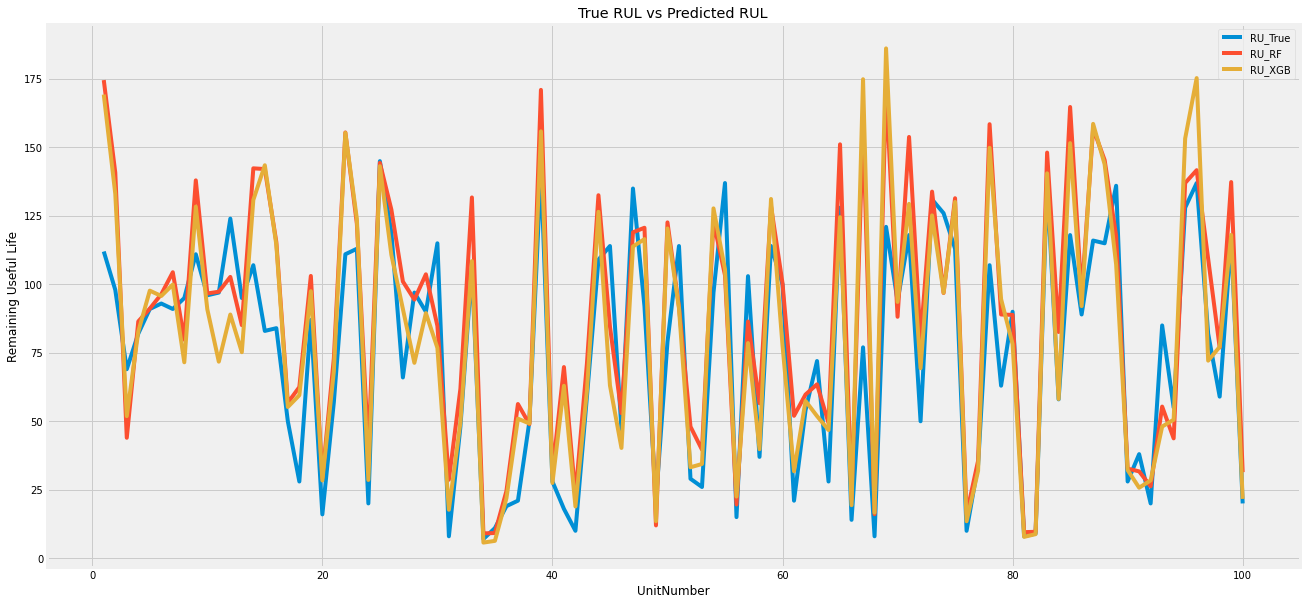

In [79]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='UnitNumber', y='RUL_true', label='RU_True', data= data_result)
sns.lineplot(x='UnitNumber', y='RUL_pred_rf', label='RU_RF', data= data_result)
sns.lineplot(x='UnitNumber', y='RUL_pred_xg', label='RU_XGB', data= data_result)
plt.title('True RUL vs Predicted RUL')
plt.ylabel('Remaining Useful Life')
plt.show()

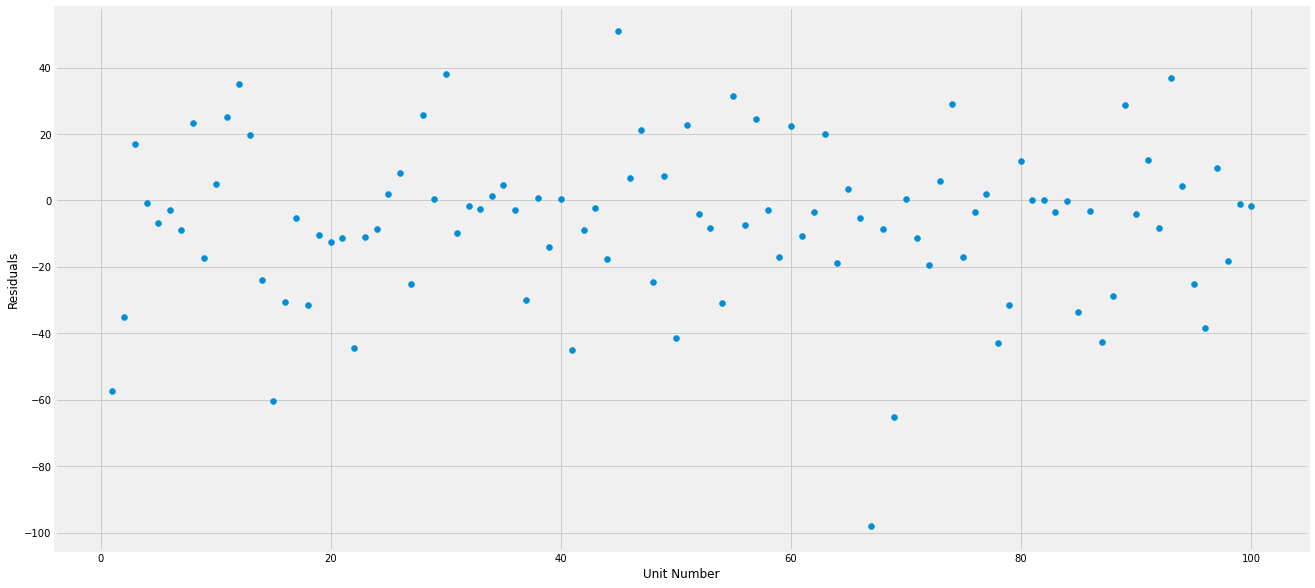

In [86]:
fig = plt.figure(figsize=(20,10))
plt.scatter(data_result['UnitNumber'], data_result['RUL_residual_xg'])
plt.xlabel('Unit Number')
plt.ylabel('Residuals')
plt.show()

## Conclusion:

Remaining useful lives have been predicted using Random Forest and XG Boost machine learning models. R-squared value, which gives variation in the dependent variable (predicted - true) explained by the independent variables. In this case XG boost model better explanation than the Random forest model. Model can be further improved by hyperparameter tuning. After obtaining the best hyperparameter, cross validation can be carried out to obtain the range of R-squared value. 